## Develop a convolutional neural network for fashion clothing classification

###  By Xiaofan Wang <br><br>

In [23]:
# baseline cnn model for fashion mnist 
from numpy import mean 
from numpy import std 
from matplotlib import pyplot 
from sklearn.model_selection import KFold 
from keras.datasets import fashion_mnist  # load dataset
from keras.utils import to_categorical    # one hot encode target values
from keras.models import Sequential       # a plain stack of layers 
from keras.layers import Conv2D           # convolution layers: create a convolution kernel that is convolved with the layer input to produce a tensor of outputs 
from keras.layers import MaxPooling2D     # pooling layers 
from keras.layers import Dense            # Dense layer(core layer): output = activation(dot(input, kernel) + bias)
from keras.layers import Flatten          # Flatten layer (reshapeing layer): flatten the inputs 
from keras.optimizers import SGD          # optimizer: stochastic gradient descent 

### 1. Introduction to Dataset  

The Fashion-MNIST dataset comprised of 60,000 small square 28*28 pixel grayscale images of items of 10 types of clothing. The mapping of all 0-9 integers to class labels is listed below:<br><br>0: T-shirt<br>1: Trouser<br>2: Pullover<br>3: Dress<br>4: Coat<br>5: Sandal<br>6: Shirt<br>7: Sneaker<br>8: Bag<br>9: Ankle boot<br>

The codes below load the Fashion-MNIST dataset using the Keras API and creates a plot of the first nine images in the training dataset.<br><br>There are 60,000 examples in the training dataset and 10,000 in the test dataset.<br>Images: All have the same square size of 28*28 pixels, grayscale. <br><br>

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


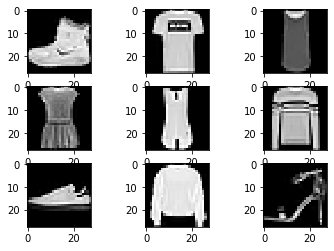

In [17]:
# load dataset 
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

#summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images 
for i in range(9):
    pyplot.subplot(330+1+i)
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))  # plot raw pixel data 
pyplot.show()

### 2. Load Dataset

（1） It is clear that the images are all pre-segmented, that the images all have the same square size of 28*28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.<br><br>
（2） It is clear that there are 10 classes and that classes are represented as unique integers. <br>Therefore, we can use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value. <br><br>

In [24]:
# load train and test dataset 
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    #reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values 
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

### 3. Prepare Pixel Data 

It is clear that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255. <br><br>Scale the pixel values for modeling:<br>(1) Convert the data type from unsigned integers to floats. <br>(2) Normalize the pixel values of grayscale images[0,255] to the range [0,1] by dividing the pixel values by the maximum value.<br><br>

In [25]:
# scale pixels 
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm/255.0
    test_norm = test_norm/255.0
    # return normalized images 
    return train_norm, test_norm 

### 4. Define Model

The model has two main aspects: the feature extraction front-end comprised of convolutional and pooling layers, and the classifier backend that will make a prediction. <br><br>(1) Convolutional front-end: start with a single convolutional layer with a small filter size(3,3) and a modest number of filters(32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier. <br><br>(2) Given that the problem is a multi-class classification, it requires an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a softmax activation function. Between the feature extractor and the output layer, it can be added a dense layer to interpret the features, in this case with 100 nodes. All layers use the ReLU activation function and the He weight initialization scheme. <br><br>(3) Stochastic gradient descent optimizer: learning rate 0.01, momentum 0.9. <br><br>(4) Opitimize the categorical cross-entropy loss function: monitor the classification accuracy metric. <br><br>


In [26]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer = 'he_uniform', input_shape = (28,28,1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(100, activation ='relu', kernel_initializer = 'he_uniform'))
    model.add(Dense(10, activation = 'softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum = 0.9)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

### 5. Evaluate Model

（1） The model can be evaluated using 5-fold cross-validation. <br>The value of k=5 was chosen to provide a baseline for both repeated evaluation and not be too large as to require a long running time. Each test set will be 20% of the training dataset, or about 12000 examples, close to the size of the actual testset. <br><br>

（2） Sample shuffling prior to being split.<br>Any model will have the same train and test datasets in each fold, providing an apples-to-apples comparison. <br><br>

（3） Train the baseline model for a modezt 10 training epochs with a default batch size of 32 examples. <br>The testset for each fold will be used to evaluate the model both during each epoch of the training run, later create learning curves to estimate the performance of the model (the classification accuracy of the fold).<br><br>


In [31]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation 
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('>%.3f' %(acc*100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

### 6. Present Results

There are two keys aspects: the diagnostics of the learning behavior of the model during training and the estimation of the model performance. <br><br>

(1) Diagnostics of the learning behavior
Creating a line plot showing model performance on the train and test set during each fold of the k-fold cross-validation. These plots are valuable for getting an idea of whether a model is overfitting, underfitting, or has a good fit for the dataset. <br>Two subplots, one for loss and one for accuracy. Blue lines will indicate model performance on the training dataset and orange lines will indicate performance on the hold out test dataset. <br><br>

(2) The classification accuracy scores collected during each fold can be summarized by calculating the mean and standard deviation. This provides an estimate of the average expected performance of the model trained on this dataset, with an estimate of the average variance in the mean.<br><br>

>91.117
>91.767
>91.042
>90.842
>91.017


/Users/grace/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/Users/grace/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/Users/grace/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: A

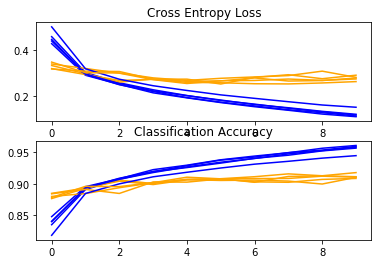

Accuracy: mean=91.157 std=0.318, n=5


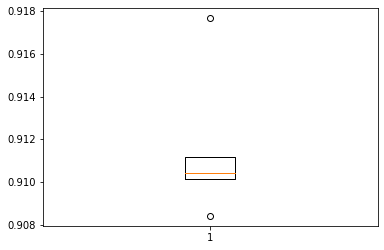

In [36]:
# plot diagnostic learning curves 
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(211)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        pyplot.subplot(212)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()
        
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()
    
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, trainX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves 
    summarize_diagnostics(histories)
    # summarize estimated performace
    summarize_performance(scores)
run_test_harness()

### 7. Improve the model 

Adding padding and increasing the number of filters.

>90.958
>91.750
>91.317
>91.375
>91.717


/Users/grace/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grace/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grace/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes 

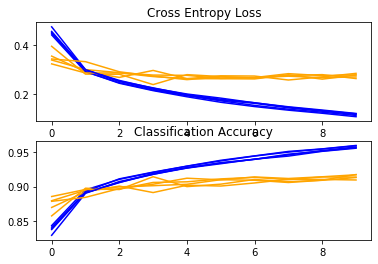

Accuracy: mean=91.423 std=0.291, n=5


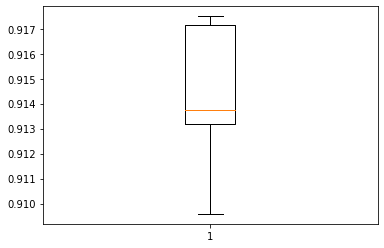

In [37]:
def define_model():
    model = Sequential()
    model.add(Conv2D(64,(3,3), padding = 'same', activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation = 'softmax'))
    # compile model
    opt=SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model 

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation 
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('>%.3f' %(acc*100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

# plot diagnostic learning curves 
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(211)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        pyplot.subplot(212)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()
        
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()
    
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, trainX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves 
    summarize_diagnostics(histories)
    # summarize estimated performace
    summarize_performance(scores)
run_test_harness()